In [4]:
# 处理数据示例
from fin_data_processor import FinDataProcessor
processor = FinDataProcessor(data_dir='./data')
df = processor.load_data(start_date='2024-04-22', end_date='2024-11-18')
df = processor.clean_data(df)
df = processor.add_calendar_features(df)
df = processor.add_features(df)
#删除掉vol列为空的行
df = df[df['vol'].notna()]
df = df.reset_index()
# df = processor.add_features(df,'spread')
df.to_feather('data.feather')

In [ ]:
import pandas as pd
# import factor_compute, factor_register, factor_manager, factors_test
# factor_register.register_all_factors()
# df = pd.read_feather('data.feather')
# factor_manager.FactorManager.get_factor_info()
# custom_config = factors_test.FactorTestConfig(
#         ic_method='spearman',
#         ic_threshold=0.03,
#         ir_threshold=0.6
#     )
# 测试单个因子
# 批量测试所有新因子
# new_factors = [
#  "microstructure_momentum"
# ]

# for factor in new_factors:
#     results = factor_compute.run_factor_compute(df, factor_name=factor)
# 测试单个因子
# 测试多个因子
# factor_list = ["time_decay", "term_premium", "volume_price_trend"]
# for factor in factor_list:
#     results = factor_compute.run_factor_compute(df, factor_name=factor)


In [ ]:
import pandas as pd
from factor_compute import *
from factor_register import *
from factor_manager import *
from factors_test import *

df = pd.read_feather("data.feather")
Manager = FactorManager()
register_all_factors()
Manager.get_factor_info()


In [ ]:
import pandas as pd
from factor_compute import *
from factor_register import *
from factor_manager import *
from factors_test import *

df = pd.read_feather("data.feather")
Manager = FactorManager()
register_all_factors()
factors_list = Manager.get_factor_names(frequency=FactorFrequency.TICK)

custom_config = FactorTestConfig(
    ic_method='spearman',
    ic_threshold=0.03,
    ir_threshold=0.6
)

for factor in factors_list:
    results = run_factor_compute(df, 
                               factor_name=factor,
                               config=custom_config,
                               return_periods=[10],
                               generate_images=False)
print(results['summary'])



In [ ]:
import pandas as pd
from factor_compute import run_factor_compute, compute_multiple_factors
from factors_test import FactorTestConfig
from factor_register import *
from factor_manager import *

df = pd.read_feather("data.feather")
Manager = FactorManager()
register_all_factors()
factor_to_compute = Manager.get_factor_names(frequency=FactorFrequency.TICK)
print("开始计算因子并调整符号...")

df_with_factors = compute_multiple_factors(df, 
                                         factor_to_compute,
                                         return_periods=[10],
                                         adjust_sign=True)  # 启用符号调整
df_with_factors.to_feather('data_with_factors.feather')
print("\n因子计算完成，结果已保存至 data_with_factors.feather")
factor_cols = [col for col in df_with_factors.columns if col in factor_to_compute]
correlation_matrix = df_with_factors[factor_cols].corr()
print("\n=== 因子相关性矩阵 ===")
print(correlation_matrix)

In [ ]:
import xgboost_signal
import pandas as pd
import tqdm
import factor_compute
import factor_register
import factor_manager
from sklearn.metrics import mean_squared_error
import factors_test
from factor_manager import *  # 确保导入FactorManager

data = pd.read_feather('data_with_factors.feather')
factor_register.register_all_factors()
Manager = FactorManager()
factors_list = Manager.get_factor_names(frequency=FactorFrequency.TICK)
factors_list = [factor for factor in factors_list if 'vpin' not in factor]
start_date = pd.to_datetime('2024-04-22')
end_date = pd.to_datetime('2024-11-18')
results = xgboost_signal.generate_rolling_signals(
    df, 
    traget='mid_price',
    feature_cols=factors_list,
    forward_periods=10,  # 10个周期后的收益率
    min_train_samples=1000)
predictions = results['predictions']
df_with_predictions = df.copy()
df_with_predictions['xgboost_pred'] = predictions
df_with_predictions.to_feather("xgboost_results/data_with_predictions.feather")

# 显示模型评估指标
print("\n\n===== 模型评估结果汇总 =====")
metrics_df = results['metrics']
print("\n时间窗口评估指标均值:")
mean_metrics = metrics_df.mean(numeric_only=True)
for metric, value in mean_metrics.items():
    print(f"{metric}: {value:.4f}")

加载数据...

将调整 30 个因子的符号

开始调整因子符号...
因子 momentum_10 无需调整 (IC: 0.0219)
因子 weighted_momentum_10 无需调整 (IC: 0.0218)
因子 momentum_20 无需调整 (IC: 0.0234)
因子 weighted_momentum_20 无需调整 (IC: 0.0232)
因子 momentum_50 无需调整 (IC: 0.0285)
因子 weighted_momentum_50 无需调整 (IC: 0.0286)
因子 momentum_100 无需调整 (IC: 0.0265)
因子 weighted_momentum_100 无需调整 (IC: 0.0272)
调整因子 realized_vol_50 的符号 (IC: -0.0026)
因子 high_low_vol_50 无需调整 (IC: 0.0044)
调整因子 realized_vol_100 的符号 (IC: -0.0012)
因子 high_low_vol_100 无需调整 (IC: 0.0029)
调整因子 realized_vol_200 的符号 (IC: -0.0001)
因子 high_low_vol_200 无需调整 (IC: 0.0018)
调整因子 volume_intensity_100 的符号 (IC: -0.0028)
因子 order_book_imbalance 无需调整 (IC: 0.0638)
因子 effective_spread 无需调整 (IC: 0.0003)
调整因子 amihud_illiquidity 的符号 (IC: -0.0024)
因子 order_flow_toxicity 无需调整 (IC: 0.0021)
因子 volume_synchronized_probability 无需调整 (IC: 0.0077)
调整因子 bid_ask_pressure 的符号 (IC: -0.0043)
调整因子 price_impact 的符号 (IC: -0.0023)
调整因子 quote_slope 的符号 (IC: -0.0012)
调整因子 price_reversal 的符号 (IC: -0.0285)
因子 hft_trend 无需调整 (IC

/var/folders/ld/dw614shd69xfrr_bqzmp3m3h0000gn/T/ipykernel_54462/1404755271.py:84: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from current font.
  plt.tight_layout()
/var/folders/ld/dw614shd69xfrr_bqzmp3m3h0000gn/T/ipykernel_54462/1404755271.py:84: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  plt.tight_layout()
/var/folders/ld/dw614shd69xfrr_bqzmp3m3h0000gn/T/ipykernel_54462/1404755271.py:84: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  plt.tight_layout()
/var/folders/ld/dw614shd69xfrr_bqzmp3m3h0000gn/T/ipykernel_54462/1404755271.py:84: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  plt.tight_layout()
/var/folders/ld/dw614shd69xfrr_bqzmp3m3h0000gn/T/ipykernel_54462/1404755271.py:84: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.tight_layout()
/var/folders/ld/dw614shd69xfrr_bqzmp3m3h0000gn/T/ipyker

相关性矩阵图已保存至 factors_correlation_adjusted.png

调整后的数据已保存至 data_with_factors_adjusted.feather


/opt/anaconda3/envs/fin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from c

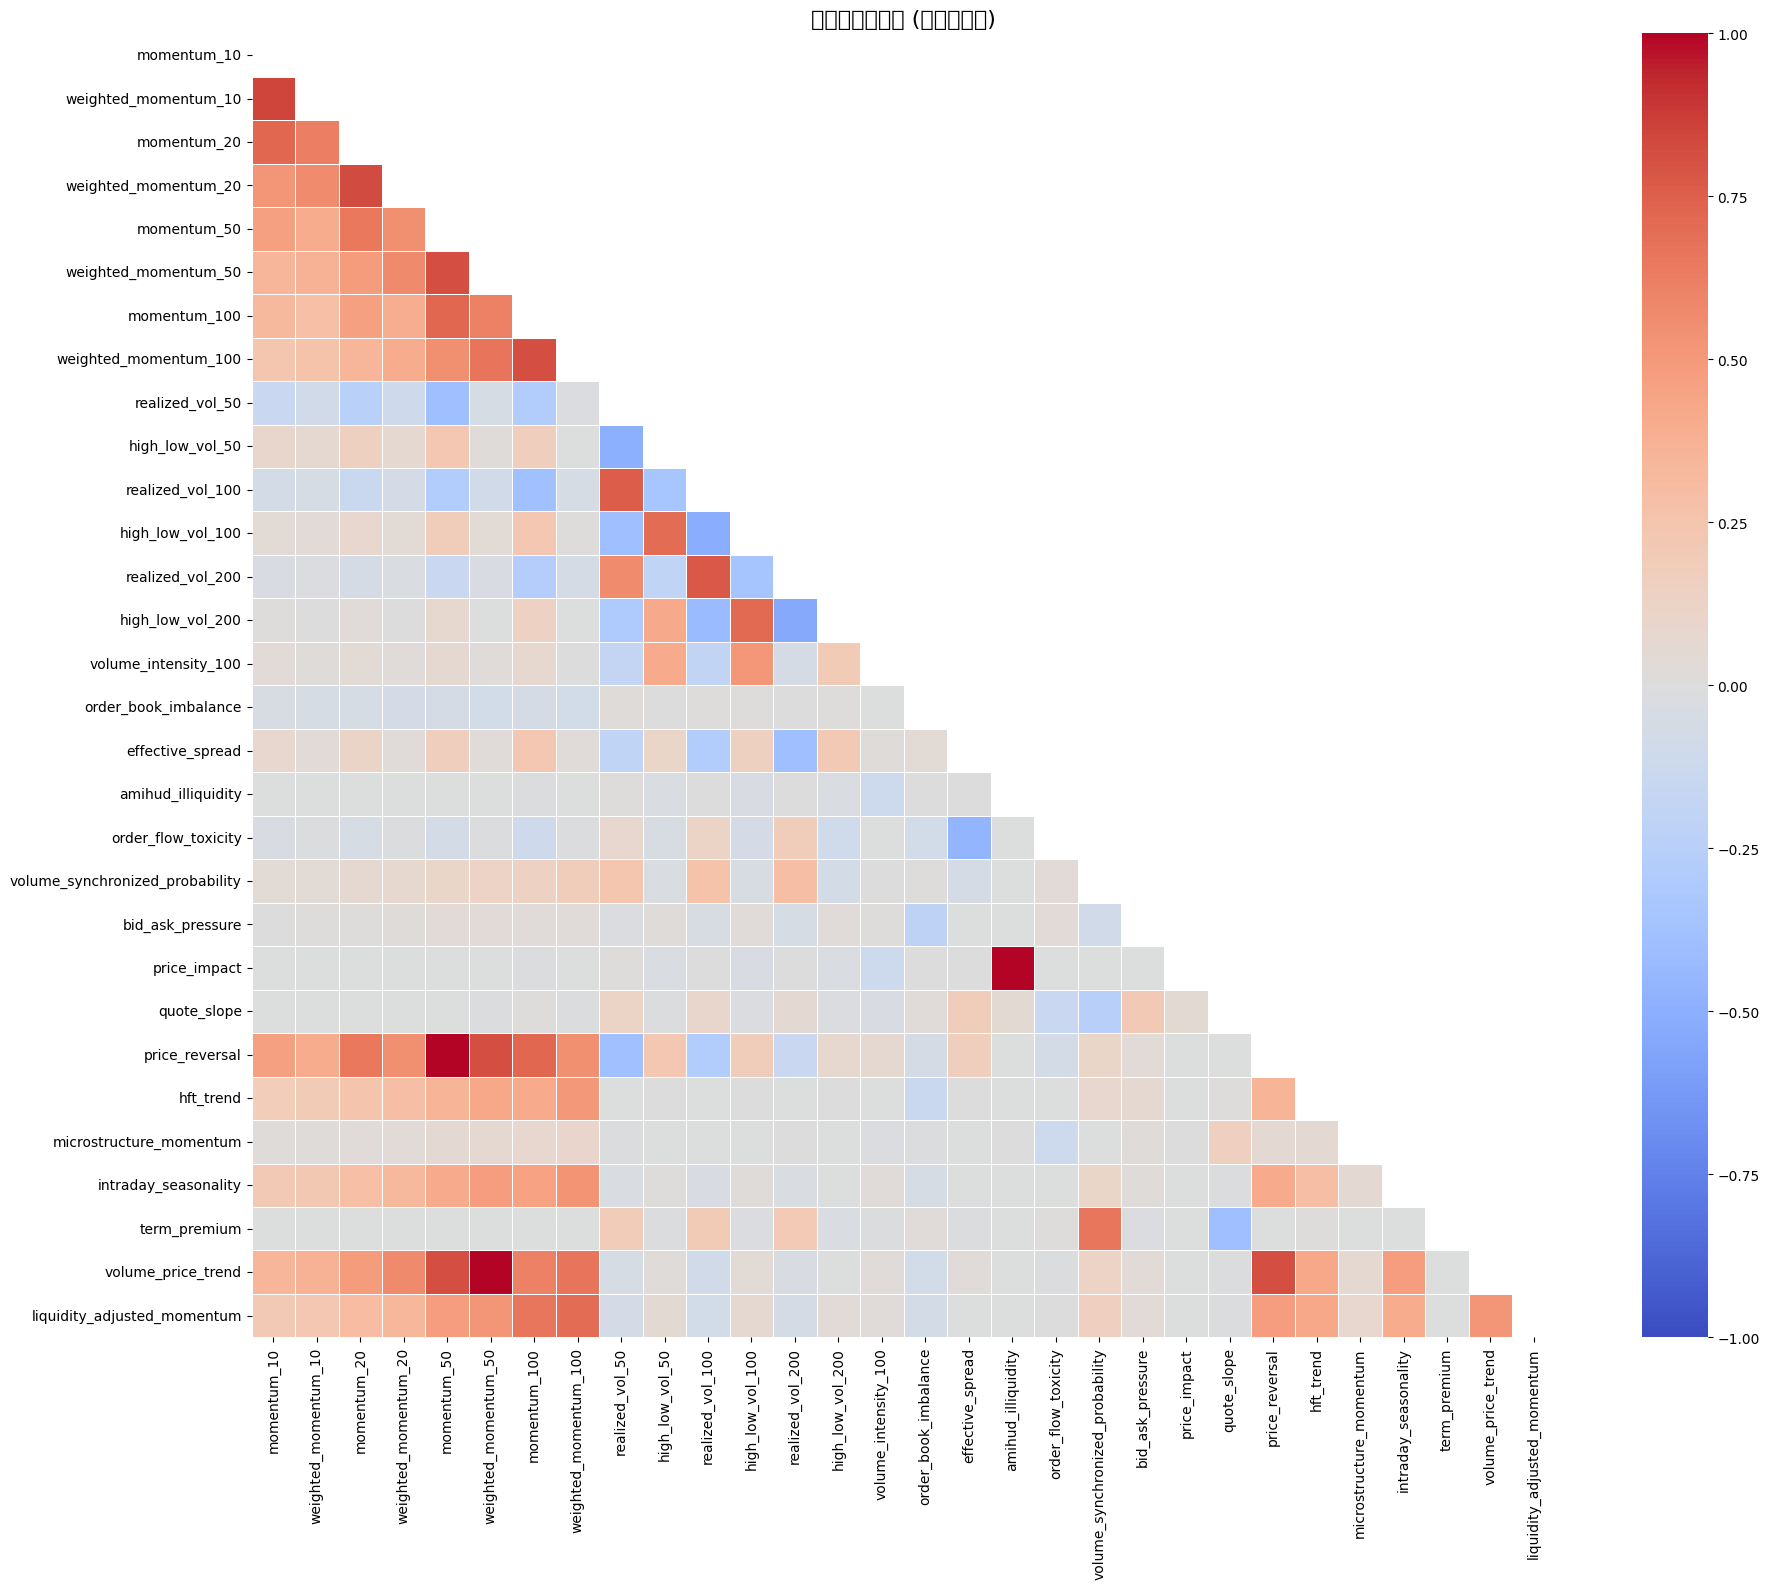

In [2]:
import pandas as pd
import numpy as np
from factor_register import register_all_factors
from factor_manager import FactorManager, FactorFrequency
from factors_test import FactorsTester, FactorTestConfig
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据
print("加载数据...")
df = pd.read_feather("data_with_factors.feather")

# 注册因子
register_all_factors()
Manager = FactorManager()
all_factors = Manager.get_factor_names(frequency=FactorFrequency.TICK)

# 筛选要调整的因子 (排除vpin)
factors_to_adjust = [factor for factor in all_factors if 'vpin' not in factor]
print(f"\n将调整 {len(factors_to_adjust)} 个因子的符号")

# 计算前向收益率
return_periods = [10]
df_with_returns = FactorsTester.calculate_forward_returns(df, periods=return_periods)

# 定义一个简化版的调整因子符号函数
def adjust_signs(data, factor_names, period=10):
    result_df = data.copy()
    adjusted_factors = []
    
    for factor_name in factor_names:
        if factor_name not in result_df.columns:
            print(f"警告: 因子 {factor_name} 不在数据中，跳过")
            continue
            
        try:
            # 计算相关系数 (IC)直接使用spearman相关系数
            valid_data = result_df[[factor_name, f'{period}period_return']].dropna()
            if len(valid_data) < 30:  # 最小样本要求
                print(f"警告: 因子 {factor_name} 有效样本不足，跳过")
                continue
                
            ic = valid_data[factor_name].corr(valid_data[f'{period}period_return'], method='spearman')
            
            # 如果IC为负，调整因子符号
            if ic < 0:
                result_df[factor_name] = -result_df[factor_name]
                print(f"调整因子 {factor_name} 的符号 (IC: {ic:.4f})")
                adjusted_factors.append(factor_name)
            else:
                print(f"因子 {factor_name} 无需调整 (IC: {ic:.4f})")
                
        except Exception as e:
            print(f"调整因子 {factor_name} 符号时出错: {str(e)}")
            continue
    
    print(f"\n调整完成! 共调整了 {len(adjusted_factors)} 个因子的符号")
    if adjusted_factors:
        print("调整的因子列表:")
        print(", ".join(adjusted_factors))
        
    return result_df

# 调整因子符号
print("\n开始调整因子符号...")
df_adjusted = adjust_signs(df_with_returns, factors_to_adjust, period=10)

# 计算相关性矩阵
print("\n计算相关性矩阵...")
# 只选择已调整的因子列
available_factors = [f for f in factors_to_adjust if f in df_adjusted.columns]
correlation_matrix = df_adjusted[available_factors].corr()

# 保存相关性矩阵
correlation_matrix.to_csv("factors_correlation_adjusted.csv")
print("相关性矩阵已保存至 factors_correlation_adjusted.csv")

# 可视化相关性矩阵
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title('因子相关性矩阵 (调整符号后)', fontsize=16)
plt.tight_layout()
plt.savefig('factors_correlation_adjusted.png', dpi=300)
print("相关性矩阵图已保存至 factors_correlation_adjusted.png")

# 保存调整后的数据
df_adjusted.to_feather("data_with_factors_adjusted.feather")
print("\n调整后的数据已保存至 data_with_factors_adjusted.feather")

In [ ]:
import pandas as pd
data = pd.read_feather('data_with_factors_adjusted.feather')
print(data.columns)